# Digital homo- and heterodyne detection

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp

import numpy as np
from scipy.special import factorial, eval_hermite
from scipy.integrate import quad
from qutip import *
from scipy.interpolate import interp1d
from scipy.stats import kstest
from joblib import Parallel, delayed


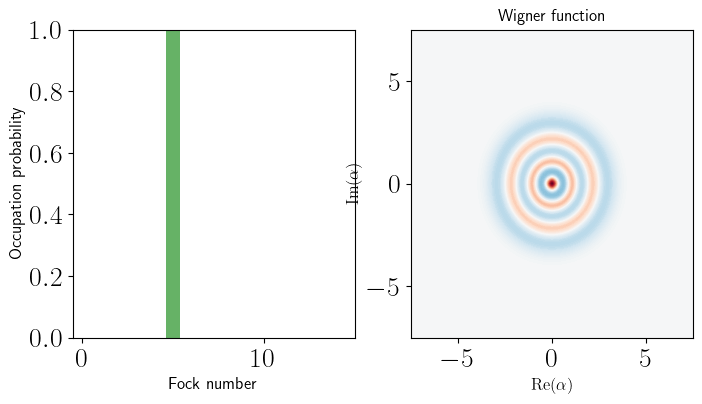

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)

#initial_cavity = fock(N,2) 

alpha = 2
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = (fock(N, 1) + fock(N,2)).unit()
initial_cavity = fock(N,5)

psi0 = tensor(initial_cavity, basis(2,0))

n_init = expect(N_cav, psi0)

plot_wigner_fock_distribution(initial_cavity);

In [3]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

## Qubit-dyne params and coupling

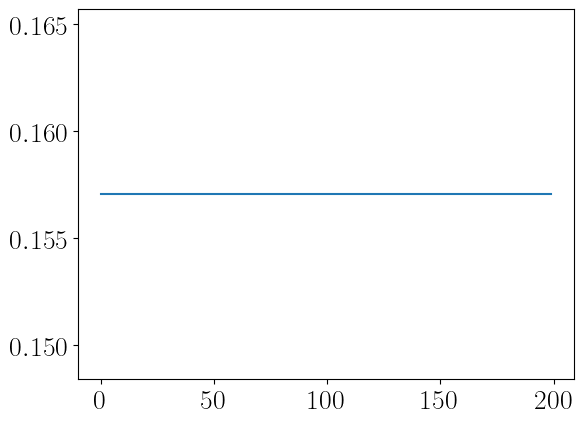

In [23]:
Nmeas = 200


dt = 0.3

nsteps = np.linspace(0,Nmeas-1,Nmeas)
tlist = nsteps*dt

swap = np.pi/2

# for consistency with the time-dependent bit coming later.
g_angle = 0.1*swap
def g_constant(i):
    return g_angle

g_timedep = g_constant

g_timedep_list = np.array([g_timedep(i) for i in range(Nmeas)])
U_ints = [U_interact(g_timedep_list[i]) for i in range(Nmeas)]

plt.plot(g_timedep_list);

## Run simulation to extract weights

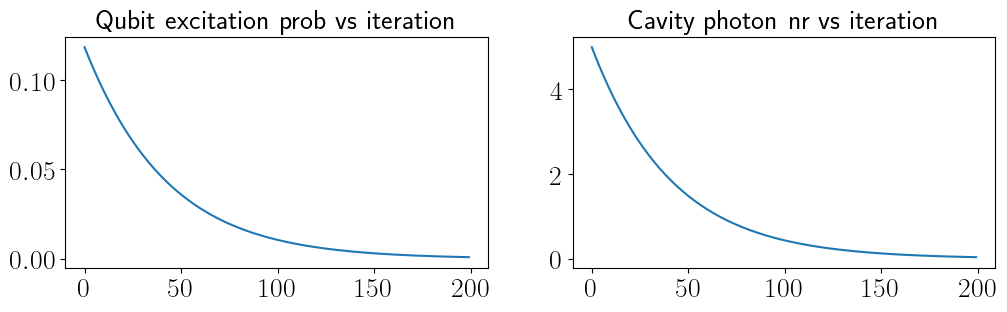

In [24]:
# Find weights by solving unconditional ME

p1exp = []
n_cav = []
rho = ket2dm(psi0)

expect_a = []

for i in range(Nmeas):
    
    n_cav.append(expect(N_cav, rho))
    U_int = U_ints[i]
    rho = U_int * rho * U_int.dag()
    
    p1val= expect(proj1, rho)
    p1exp.append(p1val)
    
    expect_a.append(expect(a,rho))
    
    rho = tensor(rho.ptrace(0),basis(2,0).proj())
    
## Define weights based on scaled qubit excitation probability
weights=np.sqrt(np.array(p1exp)/(2*n_init))

fig, axes = plt.subplots(1, 2, figsize=(12,3))

axes[0].plot(p1exp)
lbl2 = axes[0].set_title("Qubit excitation prob vs iteration")

axes[1].plot(n_cav)
lbl2 = axes[1].set_title("Cavity photon nr vs iteration")
plt.show()

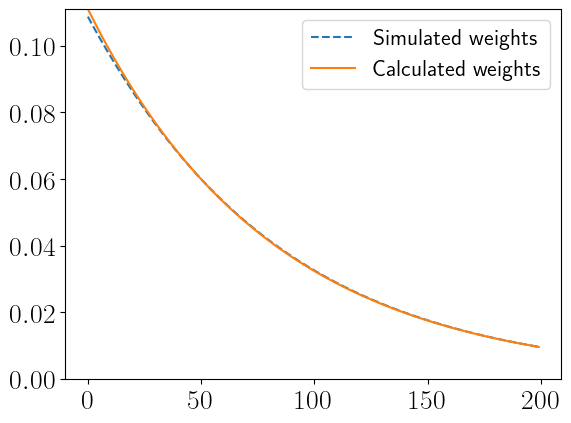

In [25]:
plt.plot(weights,'--', label='Simulated weights')

def calc_weights(step):
        g_timedep_list = np.array([g_timedep(i)/np.sqrt(dt) for i in range(step+1)])
        exponent = np.trapz(g_timedep_list**2,dx=dt)
        return  g_timedep(step)*np.sqrt(1/2)*np.exp(-exponent/2)

calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

plt.plot(calculated_weights, label='Calculated weights')
plt.ylim([0, max(calculated_weights)])
plt.legend();

### Compare simulated cavity decay with ME solution

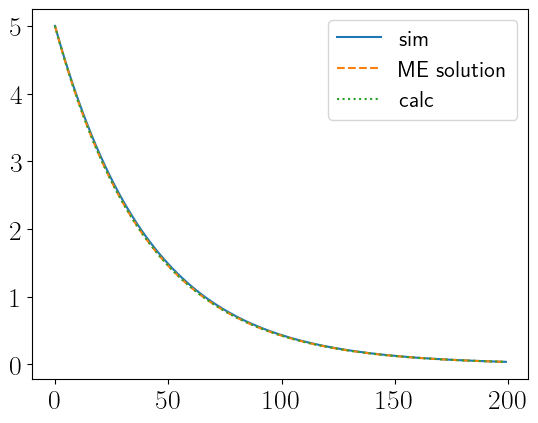

In [26]:
H_int = [(-1j) *angle * (a.dag() * sm + a * sm.dag()) for angle in g_timedep_list]

c_op=[[a,g_timedep_list/np.sqrt(dt)]] # decay rate gamma
opts = Options(nsteps=10000)

sol = mesolve(0*a, psi0, nsteps*dt, c_ops=c_op, e_ops=[N_cav], options=opts)

plt.plot(n_cav, label = 'sim')
plt.plot(nsteps, sol.expect[0], '--',label='ME solution')
#plt.plot(test, ':', label='test')
#plt.plot(alpharef**2 * np.exp(-(tlist*g)**2/5), label='meh')
#plt.plot(1/(gamma*dt)*pe,':')
#plt.plot(n_init*np.exp(-gamma*dt*nsteps), ':',label='linear analytic')

def calc_decay(step):
    g_timedep_list = np.array([g_timedep(i)/np.sqrt(dt) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return n_init*np.exp(-exponent)

calculated_decay = np.array([calc_decay(step) for step in range(Nmeas)])
#test /=  np.max(test)#np.trapz(test**2,dx=dt)
#test = alpharef**2*test
plt.plot(calculated_decay,':' ,label='calc')

plt.legend();

### Plot simulated and calculated qubit excitation probability

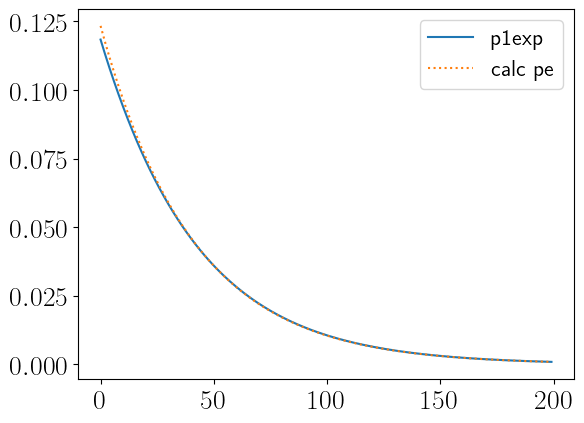

In [43]:
plt.plot(p1exp, label='p1exp')
#calc = (g*g_timedep_list)**2*dt*np.array(n_cav)

#plt.plot(calc, label='calc')
plt.plot(2*calculated_weights**2*n_init,':', label='calc pe')
plt.legend();

## Get histogram

In [9]:
# Repeated homodyne detection: calculate single homodyne shots and collect statistics
Ntrajs = 1000

qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
def get_measurements(U_ints, weights, rotangl):

    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature  
    measurements = []

    # could be parallellized
    for j in range(Ntrajs):
        # no seed, different random number every run
        xrnd = np.random.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_ints[i] * psi)

            prob = expect(proj0,psi)
            if prob>xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*weights))
    return measurements

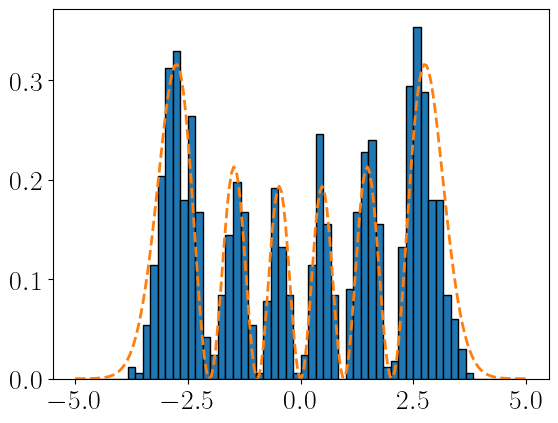

In [10]:
#get one histogram
k=5

#select quadrature
rotangle = 0
measurements = get_measurements(U_ints, weights,rotangle)
plt.hist(np.array(measurements),60,[-k,k],density=True, edgecolor='k')

x=np.linspace(-k,k,500)

# ideal distribution from Wigner marginal
x=np.linspace(-5,5,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)
plt.plot(x, marginal, 'C1--',linewidth=2)

# Time-dependent coupling

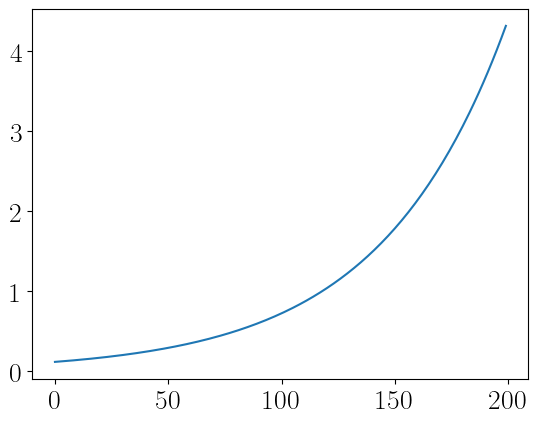

In [11]:
expspeed=0.06 # pick suitable scaling (will be state dependent)

def g_timedep_exp(step):
    return 0.12*np.exp(expspeed*step*dt) 

speed = 0.05
def g_timedep_lin(step):
    return (speed*step)**2

g_timedep = g_timedep_exp

g_timedep_list = np.array([g_timedep(i) for i in range(Nmeas)])
U_ints_timedep = [U_interact(g_timedep_list[i]) for i in range(Nmeas)]
    
plt.plot(g_timedep_list);

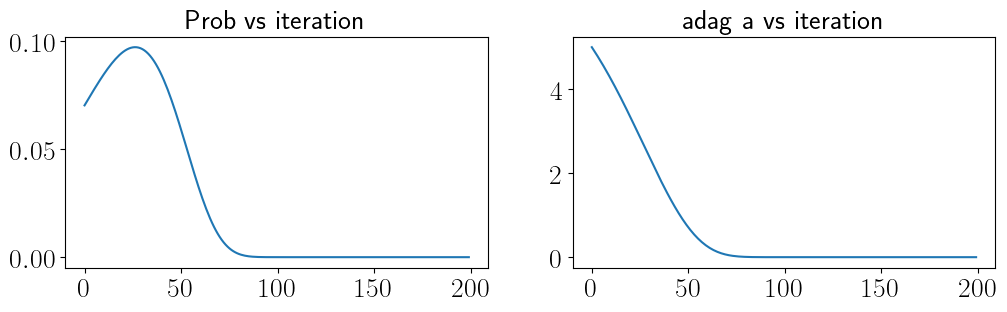

In [44]:
# Find weights by solving unconditional ME

p1exp = []
n_cav_timedep = []
rho = ket2dm(psi0)

expect_a = []

for i in range(Nmeas):
    
    n_cav_timedep.append(expect(N_cav, rho))
    U_int = U_ints_timedep[i]
    rho = U_int * rho * U_int.dag()
    
    p1val= expect(proj1, rho)
    p1exp.append(p1val)
    
    expect_a.append(expect(a,rho))
    
    rho = tensor(rho.ptrace(0),basis(2,0).proj())
    
## Define weights based on scaled qubit excitation probability
weights_timedep=np.sqrt(np.array(p1exp)/(2*n_init))

fig, axes = plt.subplots(1, 2, figsize=(12,3))

axes[0].plot(p1exp)
lbl2 = axes[0].set_title("Prob vs iteration")

axes[1].plot(n_cav_timedep)
lbl2 = axes[1].set_title("adag a vs iteration")
plt.show()

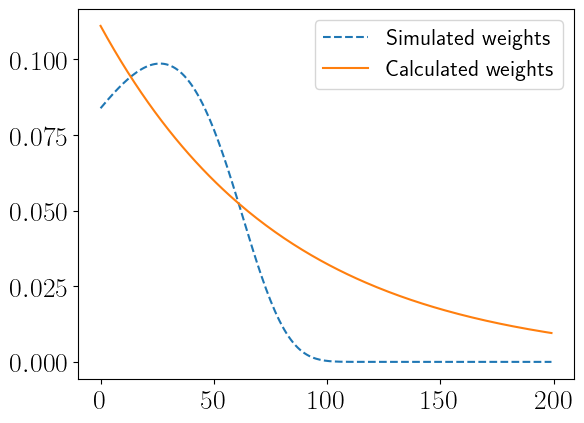

In [45]:
plt.plot(weights_timedep,'--', label='Simulated weights')

def calc_weights(step):
    g_timedep_list = np.array([g_timedep(i)/np.sqrt(dt) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return  g_timedep(step)*np.sqrt(1/2)*np.exp(-exponent/2)

calculated_weights_timedep = np.array([calc_weights(step) for step in range(Nmeas)])

plt.plot(calculated_weights_timedep, label='Calculated weights')
plt.legend();

## Get histogram

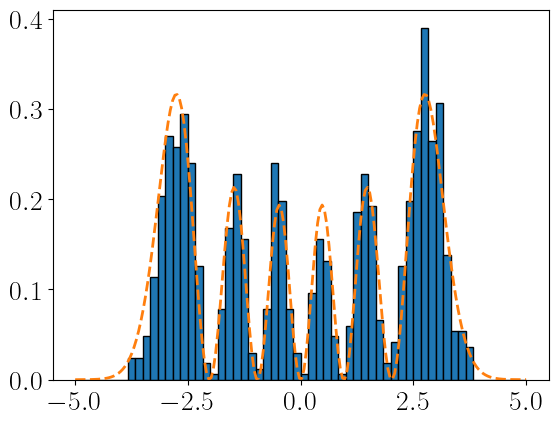

In [14]:
k=5
measurements = get_measurements(U_ints_timedep, weights_timedep, rotangle)
plt.hist(np.array(measurements),60,[-k,k],density=True, edgecolor='k')

x=np.linspace(-k,k,500)

# ideal distribution from Wigner marginal
x=np.linspace(-5,5,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)
plt.plot(x, marginal, 'C1--',linewidth=2);

# Tomography for time-dependent case

In [15]:
# homodyne angles
nangles = 10 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 30 # number of histogram bins
L = 5  # bin edge limit
dx =  2*L/Nbins # bin width


## Get measurement data
measurements = Parallel(n_jobs=-1, verbose=0, backend="loky")(delayed(get_measurements)(U_ints_timedep, weights_timedep,rotangle) for rotangle in thetas)
measurements = np.array(measurements)

b_all = []
for measurement in measurements:
    hist, _ = np.histogram(measurement, bins=Nbins, range=[-L,L], density=True)
    b_all.append(hist)

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

### Prepare operators

In [16]:
### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct operators

def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -L + i*dx, -L + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

### Convex optimization

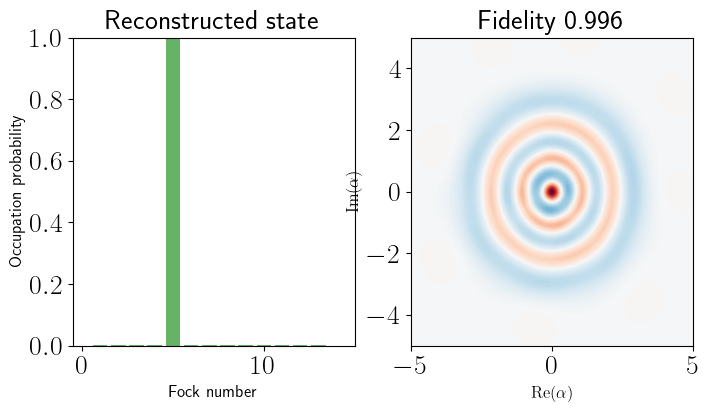

In [17]:
# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

## Plot figures

/tmp/ipykernel_2677799/659923384.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


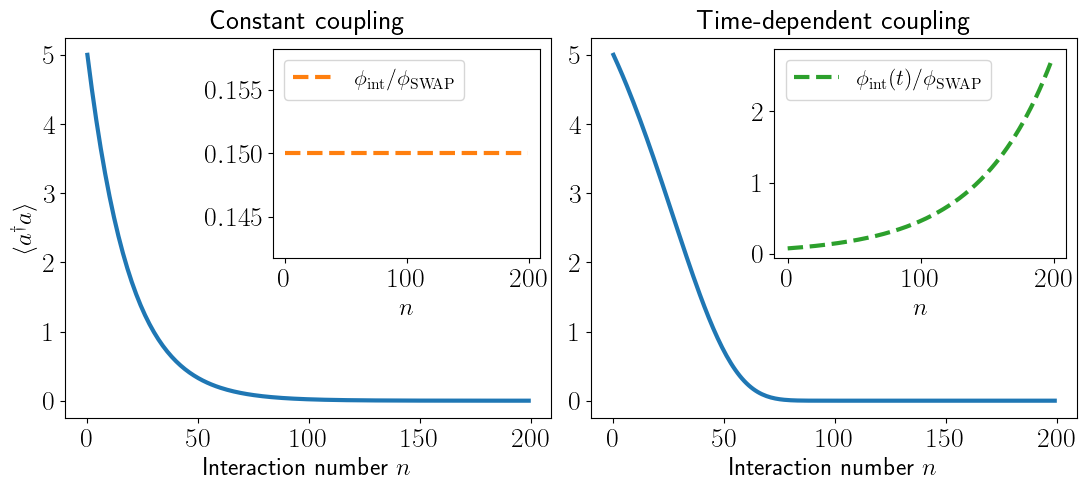

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(1,2, figsize=(11,5))

inset_xticks = [0, 100, 200]

lw=3 # linewidth
swapangle=np.pi/2

axins0 = inset_axes(ax[0], width="55%", height="55%", loc=1)
axins0.plot(nsteps, g_angle*np.ones_like(nsteps)/swap, '--', color='C1', linewidth=lw, label='$\phi_\mathrm{int}/\phi_\mathrm{SWAP}$')
#axins0.set_ylabel('Weight',fontsize=15)
axins0.set_xlabel(r'$n$')
axins0.set_xticks(inset_xticks)

ax[0].plot(nsteps, n_cav, linewidth=lw, label='Simulated') 
axins0.legend(loc='upper left')
#ax[0].set_yticks(yticks)
ax[0].set_title('Constant coupling')
ax[0].set_ylabel(r'$\langle a^\dagger a \rangle$')
ax[0].set_xlabel('Interaction number $n$')

axins1 = inset_axes(ax[1], width="60%", height="55%", loc=1)
axins1.plot(nsteps, g_timedep_exp(nsteps)/swap,'--',color='C2', linewidth=lw, label='$\phi_\mathrm{int}(t)/\phi_\mathrm{SWAP}$')

#axins1.set_ylabel('Weight',fontsize=15)
axins1.set_xlabel(r'$n$')
axins1.set_xticks(inset_xticks);

ax[1].plot(nsteps, n_cav_timedep, linewidth=lw) 
#ax[1].set_yticks(yticks)
ax[1].set_title('Time-dependent coupling')
ax[1].set_xlabel('Interaction number $n$')
#ax[1].set_ylim(ax[0].get_ylim())
axins1.legend(loc='upper left')



plt.tight_layout()
plt.savefig('compare_constant_timedep_new2.pdf')

### Old plot

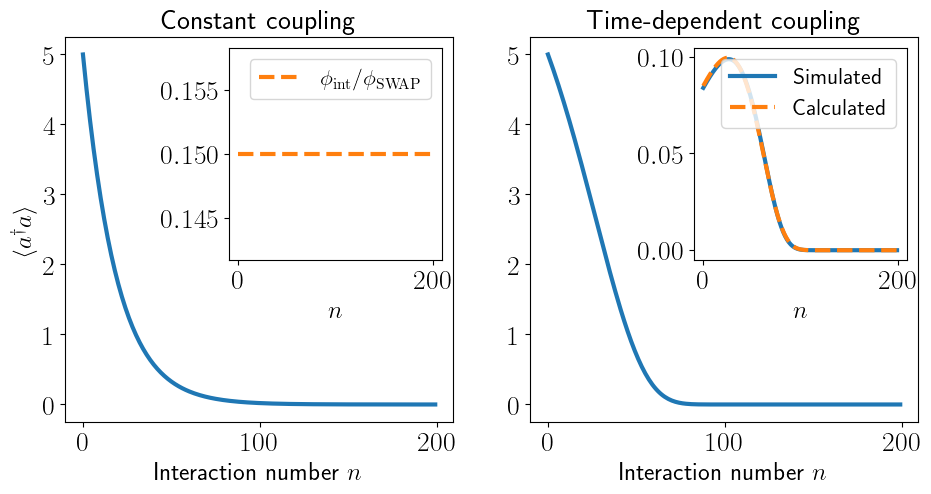

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(1,2, figsize=(11,5))

yticks = [0.00, 0.03, 0.06, 0.09, 0.12]
inset_xticks = [0, 75, 150]

lw=3 # linewidth


axins0 = inset_axes(ax[0], width="55%", height="55%", loc=1)
axins0.plot(nsteps, g_angle*np.ones_like(nsteps)/swap, '--', color='C1', linewidth=lw, label='$\phi_\mathrm{int}/\phi_\mathrm{SWAP}$')
#axins0.set_yticks([0.00, 0.05, 0.10])
#axins0.set_ylabel('$\phi_\mathrm{int}/\phi_\mathrm{SWAP}$',fontsize=15)
axins0.set_xlabel(r'$n$')
#axins0.set_xticks(inset_xticks)

ax[0].plot(nsteps, n_cav, linewidth=lw, label='Simulated') 
axins0.legend(loc='upper right')
#ax[0].set_yticks(yticks)
ax[0].set_title('Constant coupling')
ax[0].set_ylabel(r'$\langle a^\dagger a \rangle$')
ax[0].set_xlabel('Interaction number $n$')

axins1 = inset_axes(ax[1], width="55%", height="55%", loc=1)
axins1.plot(nsteps, weights_timedep, linewidth=lw, label='Simulated')
axins1.plot(nsteps, calculated_weights_timedep, '--', linewidth=lw, label = 'Calculated') 

#axins1.set_ylabel('Weight',fontsize=15)
axins1.set_xlabel(r'$n$')
#axins1.set_xticks(inset_xticks);

ax[1].plot(nsteps, n_cav_timedep, linewidth=lw) 
#ax[1].set_yticks(yticks)
ax[1].set_title('Time-dependent coupling')
ax[1].set_xlabel('Interaction number $n$')
#ax[1].set_ylim(ax[0].get_ylim())
axins1.legend(loc='upper right')



#plt.tight_layout()
#plt.savefig('compare_constant_timedep_new.pdf')